# 量化策略实例

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 工具方法
from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate, date_count_in_month, \
    get_hist_data


## 策略模块

In [2]:
%run ./shared/strategy_repo.py

from shared.strategy_repo import calendar_stgy, rotation_stgy, rotation_stgy1

## 回测模块

通过回测平台决定不同策略之间的权重。

基础数据起止日期：2004-12-31，2021-08-27


,AnnRet,AnnVol,SR,MaxDD,Calmar
hs300,0.043349,0.223302,0.194127,-0.466961,0.092832
csi500,0.032259,0.255451,0.126283,-0.651957,0.04948
account,0.114287,0.133426,0.856554,-0.243782,0.468808


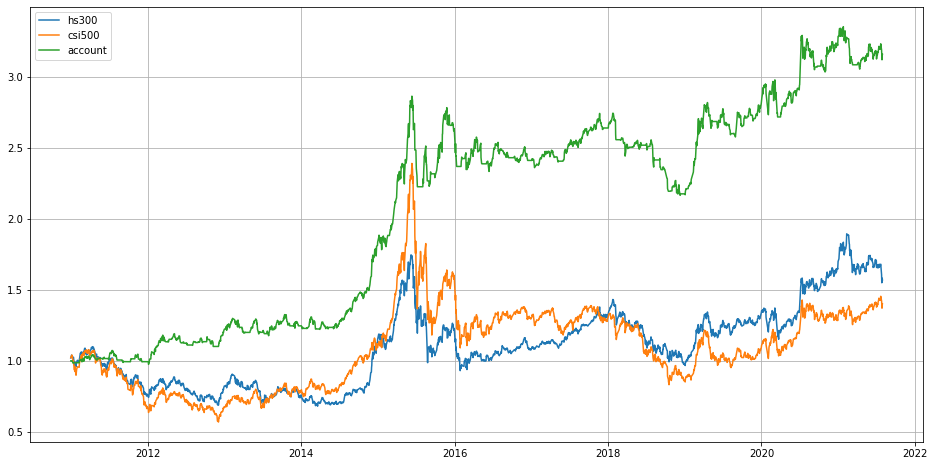

In [3]:
data_file = '../res/quant-example/basic_data.csv'

# 设置回测参数
start_date = datetime.date(2010, 12, 31)
end_date = datetime.date(2021, 7, 31)

# 读取基础数据
data = get_hist_data(data_file, end_date=end_date)

# 调用策略模块生成目标组合权重
target_wgt1 = calendar_stgy(data, start_date, end_date, params={'index_id': 'hs300', 't1': 1, 't2': 5})
target_wgt2 = calendar_stgy(data, start_date, end_date, params={'index_id': 'csi1000', 't1': 1, 't2': 5})
target_wgt3 = rotation_stgy(data, start_date, end_date, params={'N': 20})
target_wgt4 = rotation_stgy1(data, start_date, end_date, params={'N': 20})

# 多策略目标组合整合
target_wgt = 0 * target_wgt1 + 0.4 * target_wgt2 + 0 * target_wgt3 + 0.6 * target_wgt4

# 产生每日持仓权重。（假设每天都可以准确地执行交易计划）
hold_wgt = target_wgt

# 计算组合业绩
asset_ret = data.pct_change().loc[start_date:end_date]
res = (1 + asset_ret).cumprod()
res['account'] = (1 + (hold_wgt.shift(1) * asset_ret).sum(axis=1)).cumprod()

# 展示净值曲线图和业绩指标表
res.loc[:, ['hs300', 'csi500', 'account']].plot(figsize=(16, 8), grid=True)
cal_period_perf_indicator(res.loc[:, ['hs300', 'csi500', 'account']])


## 管理模块

管理模块需要根据不同策略的权重，制定出一个可行的“持仓目标”。

In [4]:
"""
开盘前
"""
# 设置拟交易日期
T = datetime.date(2020, 8, 3)
# 目标投资金额
target_amount = 100000

# 读取基础数据：截止T-1日
data = get_hist_data(data_file, end_date=T - datetime.timedelta(days=1))

# 生成目标组合权重
target_wgt1 = calendar_stgy(data, start_date=T, end_date=T, params={'index_id': 'csi1000', 't1': 1, 't2': 5})
target_wgt2 = rotation_stgy1(data, start_date=T, end_date=T, params={'N': 20})
target_wgt = 0.5 * target_wgt1 + 0.5 * target_wgt2

# 输出目标持仓市值
target_mv = target_wgt * target_amount
print('目标持仓市值：')
display(target_mv)

基础数据起止日期：2004-12-31，2021-08-27
目标持仓市值：


,csi1000,csi500,hs300,sse
2020-08-03,50000.0,50000.0,0.0,0.0


## 交易模块

这是交易的实际执行者。

通过两种方式实现交易模块：
- 自动化交易：它是通过调用交易所或第三方公司提供的交易 API 来实现的。如， CTP 接口，是上海期货交易所提供的供期货自动化交易的 API。
- 交易员手动交易。交易员会根据量化投资系统生成的交易目标，通过手动下单的方式来完成这个交易目标。

In [5]:
"""
交易时段和盘后
"""
# 盘中：按目标持仓市值完成交易
# ...

# 盘后：导出持仓明细，写入账户持仓记录表
# ...


'\n交易时段和盘后\n'

## 业绩分析模块

上面的交易模块在执行每次交易后，会把交易的成交结果记录在[账户持仓记录表](../res/quant-example/%E8%B4%A6%E6%88%B7%E6%8C%81%E4%BB%93%E8%AE%B0%E5%BD%95%E8%A1%A8.csv)中。现在就可以调用业绩分析模块，来分析盈亏。

这里需要注意的是业*绩分析模块*和*回测模块*中业绩分析部分的区别。在真实的量化投资系统中，业绩分析模块的输入一定是交易的实际成交记录，而不是回测过程中的模拟交易记录，这两者是有一定区别的。

基础数据起止日期：2004-12-31，2021-08-27


,AnnRet,AnnVol,SR,MaxDD,Calmar
hs300,0.098927,0.263281,0.375747,-0.723038,0.136821
csi500,0.121673,0.299456,0.406313,-0.724171,0.168017
account,0.18805,0.147702,1.273175,-0.29802,0.630997


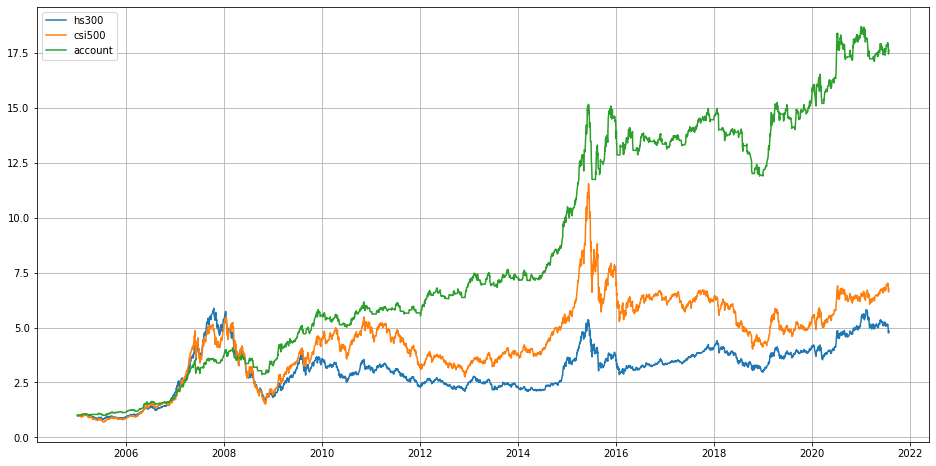

In [6]:
"""
业绩分析：定期进行
"""
# 从账户持仓记录表读取持仓市值数据
hold_mv = pd.read_csv('../res/quant-example/账户持仓记录表.csv').set_index('date')
hold_mv.index = [datestr2dtdate(e) for e in hold_mv.index]
start_date = hold_mv.index[0]
end_date = hold_mv.index[-1]

# 计算持仓权重
hold_wgt = hold_mv.iloc[:, 0:4].copy()
for t in hold_wgt.index:
    hold_wgt.loc[t] = hold_wgt.loc[t] / hold_mv.loc[t, 'amount']

# 计算每日净值
data = get_hist_data(data_file, end_date=end_date)
asset_ret = data.pct_change().loc[start_date:end_date]
# print(asset_ret)
res = (1 + asset_ret).cumprod()
# 假设系统的交易总是可以达成当天的交易目标
res['account'] = (1 + (hold_wgt.shift(1) * asset_ret).sum(axis=1)).cumprod()
# print(res)

# 展示净值曲线图和业绩指标表
res.loc[:, ['hs300', 'csi500', 'account']].plot(figsize=(16, 8), grid=True)
cal_period_perf_indicator(res.loc[:, ['hs300', 'csi500', 'account']])


### 资金曲线

计算资金曲线的 20 日均线。

<AxesSubplot:>

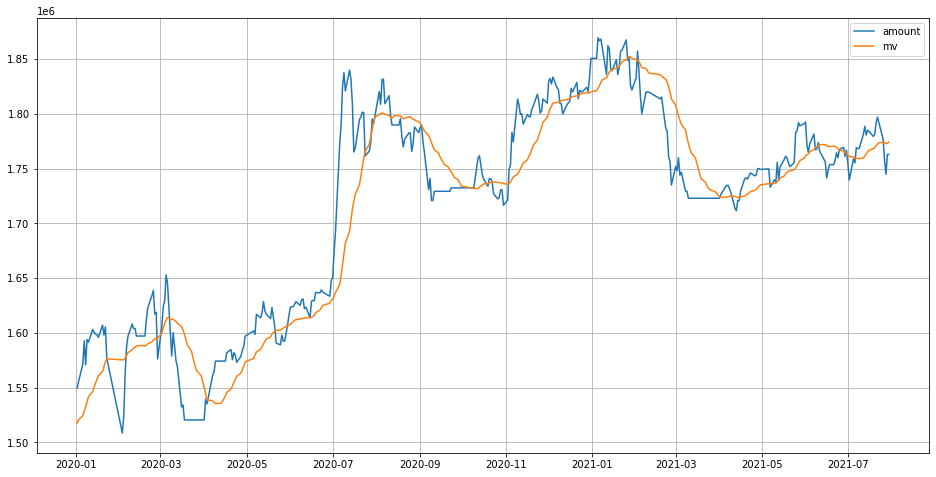

In [9]:
N = 20
start_date = datetime.date(2020, 1, 1)
hold_mv['mv'] = hold_mv['amount'].rolling(N).mean()
hold_mv.loc[start_date:, ['amount', 'mv']].plot(figsize=(16, 8), grid=True)
